## Supervised Learning Final Project: Modelling Insurance Costs

**The problem**: A fictional insurance company, Mass Insurance, needs a way to calculate what they should charge their clients based on client-specific factors (e.g. is the client a smoker?)

**The solution**: We will train and refine a multivariate OLS (ordinary least squares) regression model for this exact purpose, such that Mass Insurance can input determining factors into the model and the model will return the amount that they should charge their new client.

### The data
Our data is a public dataset that was sourced from Kaggle (see citation below) and downloaded as a CSV. It consists of over a thousand records that represent insured individuals, including what their (presumably annual) insurance charges are and as well as various health factors, such as if the individual is a smoker, their age, etc.

*APA Citation*: Jain, Simran. (2020). Insurance Premium Data. [Data set]. Kaggle. https://www.kaggle.com/datasets/simranjain17/insurance

 <u>**Data breakdown**</u> 
 
 **Number of records**: 1338
 
 **Number of columns**: 7
 
 **Dependent variable**
- **Charges**: *float* - The amount that the insured pays for insurance (presumably annual)
        
 **Independent variables**
- **Age**: *integer* - The age of the insured
- **Sex**: *category (male, female)* - The sex of the insured
- **BMI**: *integer* - The BMI (body mass index) of the insured
- **Children**: *integer* - The number of children of the insured
- **Smoker**: *category (yes, no)* - Whether the insured is a smoker
- **Region**: *category (southwest, southeast, northwest, northeast)* - The region where the insured lives
        

In [890]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import sklearn.model_selection
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('insurance.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.4+ KB
None


**Data Cleaning Pt 1**

The first thing we notice in analyzing our data is that there appears to be 1339 entries, but each column has 1338 non-null entries - meaning that we have an empty row, probably at the end of the CSV.  Let's go ahead and drop that row, and any rows with NaN values.

In [891]:
# drop rows where any value is NaN
data = data.dropna(how='any')
# validate our cleaning
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 83.6+ KB
None


**Data Cleaning Pt 2**

Let's check our data for any outliers, valid or invalid, that might skew our results.  We can do this by plotting a histogram for each of our numerical features.

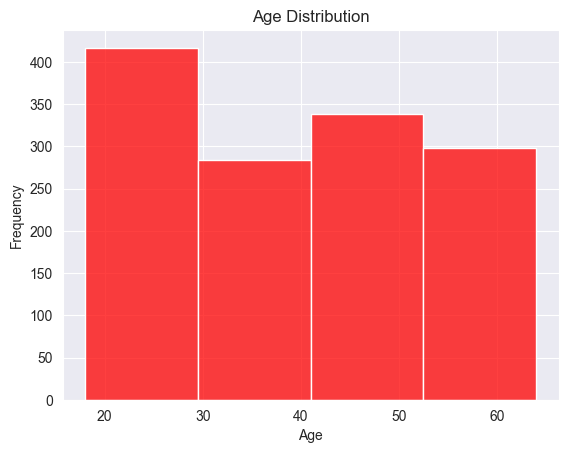

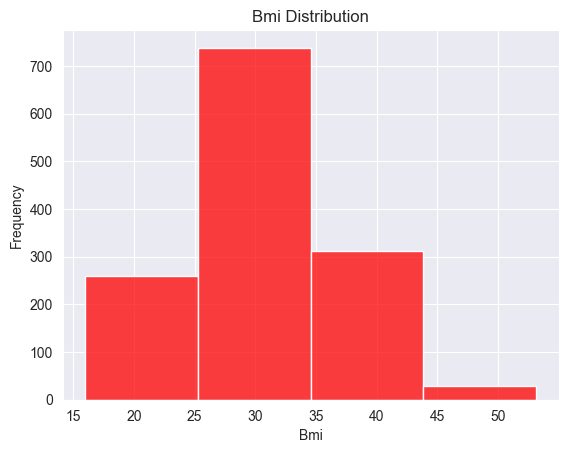

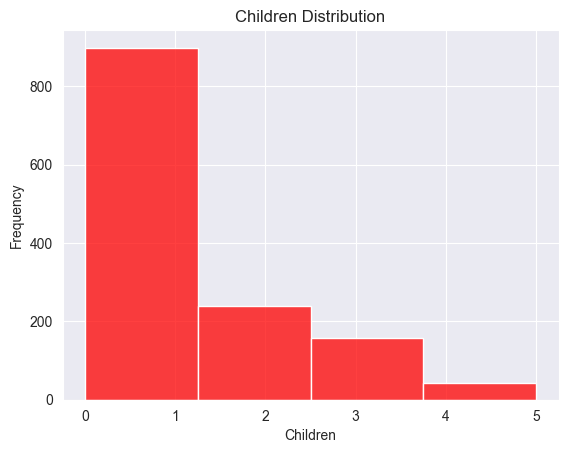

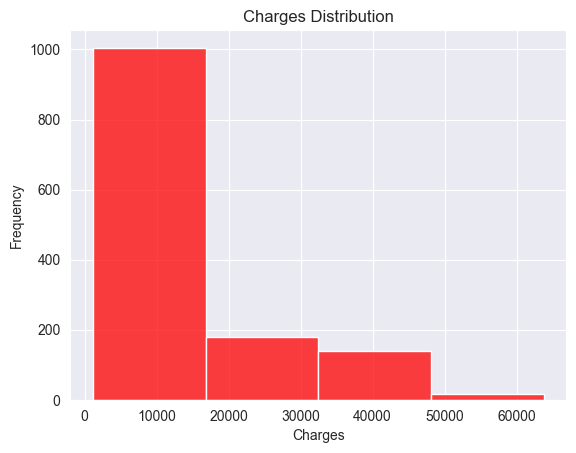

In [892]:
features = ['age', 'bmi', 'children', 'charges']

# iterate over our numerical features and plot a histogram to easily detect outliers
for feature in features:
    sns.histplot(data[feature], bins=4, kde=False, color='red')
    plt.title(f'{feature.capitalize()} Distribution')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()


**Data Cleaning Conclusions**

Really, this dataset is already very clean - we just needed to drop the empty row and, as we will see later in the *Feature Engineering* section, perform some encoding on our categorical features.

**EDA Pt 1**

Let's go ahead and generate a correlation matrix and heatmap for our currently available numerical features.

As we can see from the heatmap, we don't really have any features with strong correlations to `charges` at this point.

Axes(0.125,0.11;0.62x0.77)


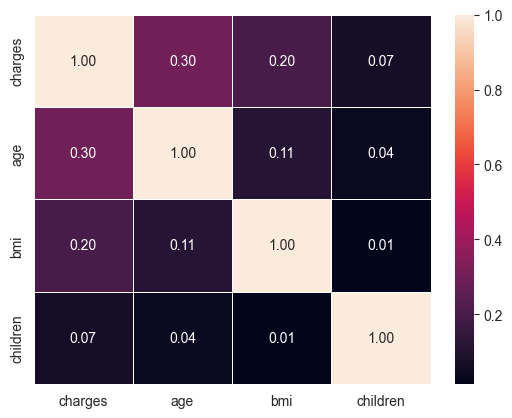

In [893]:
# move `charges` to first column position - this is needed for correlation matrix to parse it as the dependent variable
cols = ['charges'] + [col for col in data if col != 'charges']
data = data[cols]

# remove all categorical features - we will add these in later, once they have been engineered
prelim_eda_data = data.select_dtypes(include=['int64', 'float64'])

# generate correlation matrix and heatmap
corr = prelim_eda_data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Feature Engineering Pt 1**
 
As you saw from the previous heatmap, it doesn't seem like we have a lot to work with when we omit our categorical features.

As such, let's go ahead and try and encode some of these categorical features such that we can potentially use them in our model.

The first, and easiest to encode, is the `smoker` feature, which describes whether the insured is a smoker.  This has a value of `yes` or `no`, which we will convert to binary (`0` or `1`).

In [894]:
# encode smoker to binary
smoker_map = {'yes': 1, 'no': 0}
data['smoker'] = data['smoker'].apply(lambda x: smoker_map[x])

**Models: Feature Engineering Pt 2**

Next, we have a couple of categorical features (`sex` and `region`) which are slightly harder to encode as they are not ordinal categorical variables and
thus cannot be encoded into integers.

For these features, we will need to use one-hot encoding, which basically unzips each feature into multiple columns, where each column represents a category of the feature and is assigned a binary value.  Ex. `sex` can be `male` or `female`.  One-hot encoding would create the columns `sex_male` and `sex_female` and, in a given row where `sex` = `male`, `sex_male` would be assigned the value of `1` while `sex_female` would be 0.

We can easily one-hot encode both of these features using the pandas `get_dummies` method.


In [895]:
# one-hot encoding for categorical variables.  get_dummies also removes the original columns, which makes things even easier for us.
data = pd.get_dummies(data, columns=['sex', 'region'], dtype='int')

# validate that all features are now numeric
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charges           1338 non-null   float64
 1   age               1338 non-null   float64
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   float64
 4   smoker            1338 non-null   int64  
 5   sex_female        1338 non-null   int64  
 6   sex_male          1338 non-null   int64  
 7   region_northeast  1338 non-null   int64  
 8   region_northwest  1338 non-null   int64  
 9   region_southeast  1338 non-null   int64  
 10  region_southwest  1338 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 125.4 KB
None


**EDA Pt 2**

Now that our categorical features are encoded, we can perform another round of EDA with all features now available.

Based on the heatmap below, we will probably want to focus on the `smoker`, `age`, and `bmi` features, as these are the features most highly correlated with `charges`.

Axes(0.125,0.11;0.62x0.77)


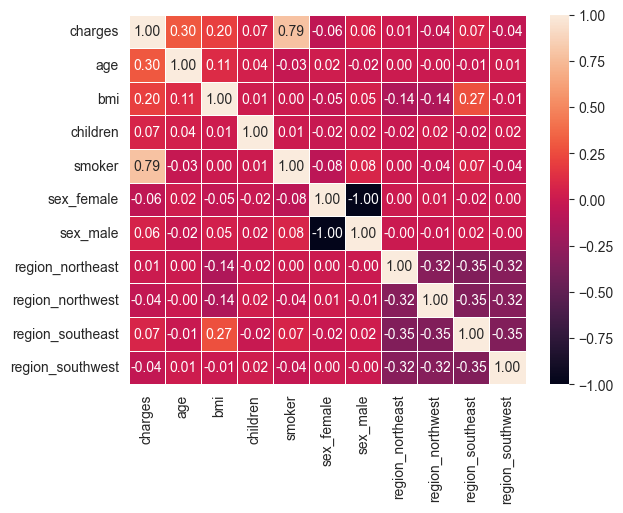

In [896]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Feature Engineering Pt 3**

Given our EDA findings, we can now select our features.
 
We are going to drop all features except for `smoker`, `age`, and `bmi` since these were the features with the highest correlation with `charges`.

In [897]:
data = data[['charges', 'smoker', 'age', 'bmi']]

**Models: Multi-Linear Regression/Collinearity**

Now that we have selected our features, we can see that these features do not display collinearity or even high correlation as each feature's correlation with each other is quite low.

This is easy to see when reviewing a heatmap of only our selected features - the highest correlation between features is only `0.11` between `age` and `bmi`, which is negligible.


Axes(0.125,0.11;0.62x0.77)


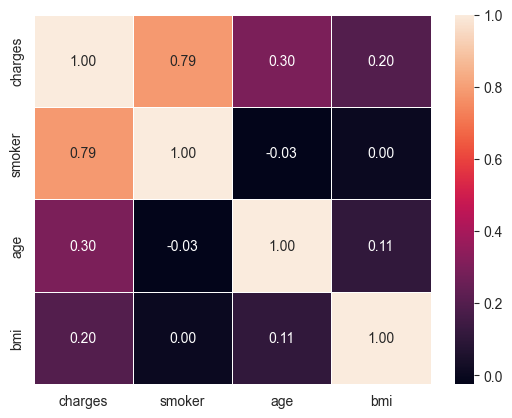

In [898]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: Multiple ML Models Pt 1**

For our problem, a regression model seems most appropriate, since we are trying to determine what to charge the insured and not whether they should be covered, or some other binary classification.

Using our useful features we generate some models...



In [899]:
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.2)

useful_features = ['smoker','age','bmi']

models = []

formula = 'charges~'

for feature in useful_features:
    formula = f'{formula}+{feature}'
    model = smf.ols(formula=formula, data=X_train).fit()
    models.append(model)
    
for model in models:
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     1822.
Date:                Fri, 24 May 2024   Prob (F-statistic):          4.43e-233
Time:                        09:05:05   Log-Likelihood:                -11050.
No. Observations:                1070   AIC:                         2.210e+04
Df Residuals:                    1068   BIC:                         2.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8396.5958    252.532     33.250      0.0

**Models - multiple models pt 2**

Here, we see if using polynomials will help.

0.7610257786939663
0.7616909729348641
0.7634411901971245
0.7638709157649736
0.7644183012770687
0.7643986804790589
0.7641852335291959
0.13217850023168187


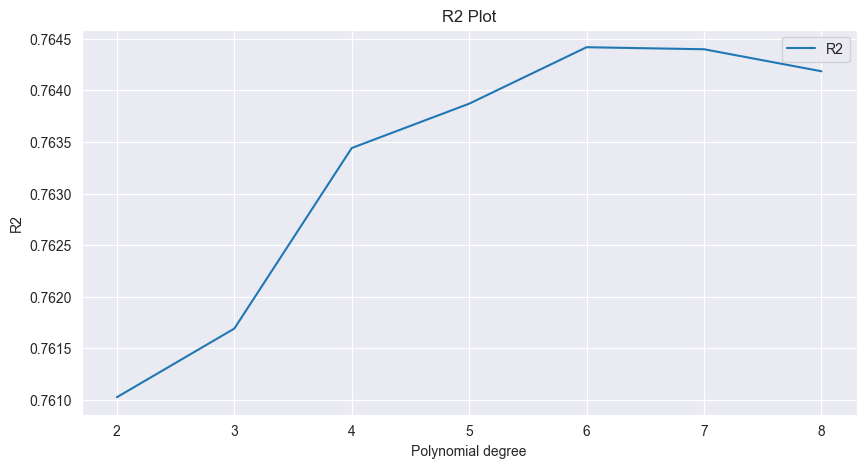

In [900]:
poly_models = []

formula = 'charges~smoker+age+bmi'

powers = []

for i in range(2,10):
    powers.append(i)
    formula = f'{formula}+np.power(smoker,{i})+np.power(age,{i})+np.power(bmi,{i})'
    poly_model = smf.ols(formula=formula, data=X_train).fit()
    print(poly_model.rsquared)
    poly_models.append(poly_model)
    
poly_models = poly_models[:-1]
powers = powers[:-1]
r2s = [model.rsquared for model in poly_models]

data = pd.Series(r2s)
df = pd.DataFrame({'X': powers, 'R2': data})
df.plot(x='X', y='R2', figsize=(10, 5), title='R2 Plot', legend=True, grid=True, label='R2')
plt.xlabel('Polynomial degree')
plt.ylabel('R2')


plt.show()


**Results analysis**

Here, we analyze our results from each model - first, the multi-linear.

MSE 42916740.373216115
R2 0.6967392839336773
MAE 4573.74146496197
Mean charges: 13574.297292611931


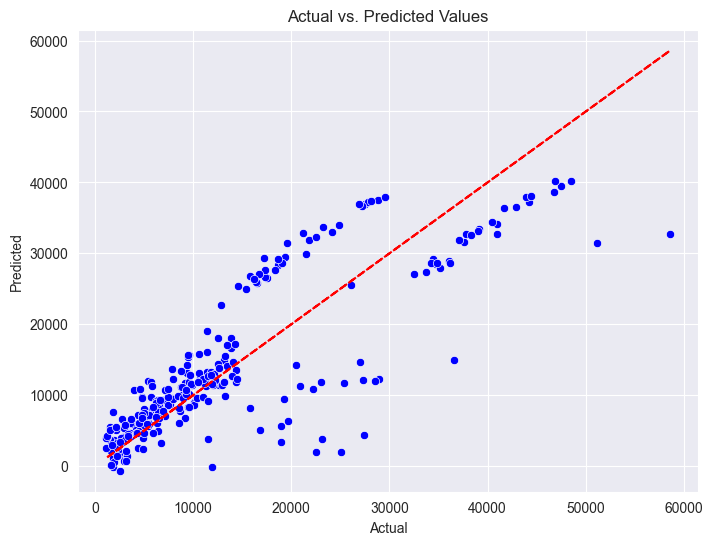

In [901]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = models[2].predict(X_test)
y_test = X_test['charges']

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE {mse}')
print(f'R2 {r2}')
print(f'MAE {mae}')

mean_charges = sum(y_test) / len(y_test)
print(f'Mean charges: {mean_charges}')

# results plot
data = pd.DataFrame({    'Actual': y_test,    'Predicted': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, marker='o', color='blue')
plt.plot(data['Actual'], data['Actual'], 'r--')  # Red dashed line for perfect prediction
plt.title('Actual vs. Predicted Values')
plt.show()






Next, the multivariate polynomial...

MAE 4550.902343759507
MAE 4515.395193024933
MAE 4542.134020015568
MAE 4535.835375206778
MAE 4550.02465052692
MAE 4532.145574517579
MAE 4524.681109765343


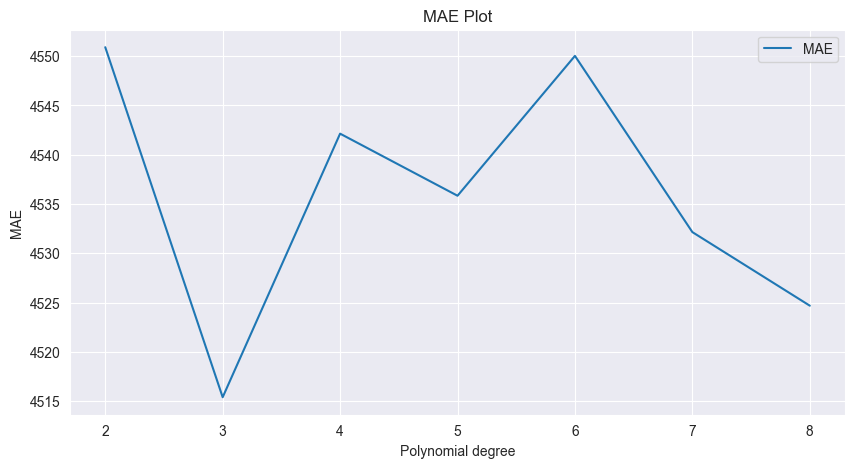

In [902]:

from sklearn.metrics import mean_squared_error, r2_score

maes = []

for poly in poly_models:

    y_pred = poly.predict(X_test)
    y_test = X_test['charges']
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    
    print(f'MAE {mae}')

data = pd.Series(maes)
df = pd.DataFrame({'X': powers, 'R2': maes})
df.plot(x='X', y='R2', figsize=(10, 5), title='MAE Plot', legend=True, grid=True, label='MAE')
plt.xlabel('Polynomial degree')
plt.ylabel('MAE')
plt.show()


**Conclusions**

*Learning and Takeaways:*

I found it interesting that a binary feature, `smoker`, had such a high correlation with `charges`.  Of course it makes sense - being a smoker is highly detrimental to health and premiums are typically higher for smokers, but it's not the feature that I expected to have the highest correlation.

*Something that Didn't Work:*

Our polynomial models were a slight failure.  They had higher R2 values, but their MAEs were also higher indicating that they may have been overfit.

*Ways to Improve:*

Possibly experimenting more with weighted models or otherwise more complex models in order to achieve a better fit.  Possibly implement some more complex feature engineering.